## Section 1: Setup and Import Libraries

In [2]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from datetime import datetime
import os

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Explainability libraries
try:
    import shap
    SHAP_AVAILABLE = True
    print("✅ SHAP library loaded successfully")
except ImportError:
    SHAP_AVAILABLE = False
    print("⚠️ SHAP not available. Install: pip install shap")

try:
    import lime
    import lime.lime_tabular
    LIME_AVAILABLE = True
    print("✅ LIME library loaded successfully")
except ImportError:
    LIME_AVAILABLE = False
    print("⚠️ LIME not available. Install: pip install lime")

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("\n📦 All libraries loaded successfully!")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ SHAP library loaded successfully
✅ LIME library loaded successfully

📦 All libraries loaded successfully!
Analysis Date: 2025-12-26 06:30:01


## Section 2: Load Model and Data with Smart Pairing

In [3]:
print("\n🔍 LOADING MODEL AND DATA")
print("="*80)

# Try multiple model-data combinations
model_data_pairs = [
    {
        'model_file': 'xgboost_clean_no_leakage.pkl',
        'model_name': 'XGBoost Clean (No Leakage)',
        'split_file': 'clean_train_test_split_no_leakage.pkl',
        'feature_file': 'clean_feature_names_no_leakage.pkl'
    },
    {
        'model_file': 'baseline_clean_model.pkl',
        'model_name': 'Baseline Clean Model',
        'split_file': 'clean_train_test_split.pkl',
        'feature_file': 'clean_feature_names.pkl'
    },
    {
        'model_file': 'optimized_flight_risk_model.pkl',
        'model_name': 'Optimized Model',
        'split_file': 'train_test_split.pkl',
        'feature_file': 'optimized_feature_names.pkl'
    }
]

# Try each combination
model_loaded = False
for pair in model_data_pairs:
    try:
        print(f"\n🔄 Trying: {pair['model_name']}...")
        
        # Load model
        model_path = f"../models/{pair['model_file']}"
        if not os.path.exists(model_path):
            print(f"   ⚠️ Model file not found: {pair['model_file']}")
            continue
        
        model = joblib.load(model_path)
        print(f"   ✅ Model loaded: {type(model).__name__}")
        
        # Load train-test split
        split_path = f"../models/{pair['split_file']}"
        if not os.path.exists(split_path):
            print(f"   ⚠️ Split file not found: {pair['split_file']}")
            continue
            
        split_data = joblib.load(split_path)
        X_train = split_data['X_train']
        X_test = split_data['X_test']
        y_train = split_data['y_train']
        y_test = split_data['y_test']
        print(f"   ✅ Data loaded: {X_test.shape}")
        
        # Load feature names
        feature_path = f"../models/{pair['feature_file']}"
        if os.path.exists(feature_path):
            feature_names = joblib.load(feature_path)
        else:
            feature_names = list(X_test.columns)
        print(f"   ✅ Features: {len(feature_names)}")
        
        # Validate compatibility
        if hasattr(model, 'n_features_in_'):
            expected_features = model.n_features_in_
            actual_features = X_test.shape[1]
            
            if expected_features != actual_features:
                print(f"   ❌ Feature mismatch: Expected {expected_features}, got {actual_features}")
                continue
        
        # Test prediction
        test_pred = model.predict(X_test[:5])
        print(f"   ✅ Prediction test passed")
        
        model_name = pair['model_name']
        model_loaded = True
        print(f"\n✅ Successfully loaded: {model_name}")
        break
        
    except Exception as e:
        print(f"   ❌ Failed: {str(e)}")
        continue

if not model_loaded:
    raise Exception("❌ Could not load any compatible model-data pair!")

# Display summary
print("\n" + "="*80)
print("📊 DATA SUMMARY")
print("-"*80)
print(f"Model: {model_name}")
print(f"Model Type: {type(model).__name__}")
print(f"Training Set: {X_train.shape[0]:,} samples, {X_train.shape[1]} features")
print(f"Test Set: {X_test.shape[0]:,} samples, {X_test.shape[1]} features")
print(f"Feature Names: {len(feature_names)}")
print(f"Class Distribution: {np.bincount(y_test.values)}")
print(f"Positive Class Rate: {y_test.mean():.2%}")
print("="*80)


🔍 LOADING MODEL AND DATA

🔄 Trying: XGBoost Clean (No Leakage)...
   ✅ Model loaded: XGBClassifier
   ✅ Data loaded: (16997, 23)
   ✅ Features: 23
   ✅ Prediction test passed

✅ Successfully loaded: XGBoost Clean (No Leakage)

📊 DATA SUMMARY
--------------------------------------------------------------------------------
Model: XGBoost Clean (No Leakage)
Model Type: XGBClassifier
Training Set: 67,986 samples, 23 features
Test Set: 16,997 samples, 23 features
Feature Names: 23
Class Distribution: [12399  4598]
Positive Class Rate: 27.05%


## Section 3: Model Performance Baseline

In [3]:
print("\n📊 MODEL PERFORMANCE BASELINE")
print("="*80)

# Generate predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Classification report
print("\n" + classification_report(y_test, y_pred, 
                                   target_names=['Not Severe', 'Severe']))

print("\n✅ Baseline performance established")
print("Now proceeding to explainability analysis...")


📊 MODEL PERFORMANCE BASELINE



Accuracy: 0.9126 (91.26%)

              precision    recall  f1-score   support

  Not Severe       0.91      0.98      0.94     12399
      Severe       0.93      0.73      0.82      4598

    accuracy                           0.91     16997
   macro avg       0.92      0.86      0.88     16997
weighted avg       0.91      0.91      0.91     16997


✅ Baseline performance established
Now proceeding to explainability analysis...


## Section 4: SHAP Analysis - Global Feature Importance

SHAP (SHapley Additive exPlanations) values show:
- How much each feature contributes to predictions
- Direction of impact (positive/negative)
- Feature interactions

In [9]:
print("\n🔍 SHAP ANALYSIS - GLOBAL FEATURE IMPORTANCE")
print("="*80)

if not SHAP_AVAILABLE:
    print("⚠️ SHAP not available. Install with: pip install shap")
else:
    try:
        # Use smaller sample for speed
        sample_size = min(200, len(X_test))
        X_sample = X_test.iloc[:sample_size].copy()
        y_sample = y_test.iloc[:sample_size].copy()
        
        print(f"Using {sample_size} samples for SHAP analysis...")
        print("⏳ Preparing data and creating explainer...\n")
        
        # CRITICAL FIX: Convert all data to numeric to fix string-to-float error
        print("Converting data to numeric format...")
        X_sample_numeric = X_sample.copy()
        for col in X_sample_numeric.columns:
            X_sample_numeric[col] = pd.to_numeric(X_sample_numeric[col], errors='coerce')
        X_sample_numeric = X_sample_numeric.fillna(0)
        print(f"✅ Data validated: {X_sample_numeric.shape}, all numeric\n")
        
        # Use KernelExplainer (model-agnostic, more robust for problematic models)
        print("Creating KernelExplainer (model-agnostic approach)...")
        print("Note: This may take 3-5 minutes due to model-agnostic sampling\n")
        
        # Use smaller background for speed
        background_size = min(100, len(X_train))
        X_background = X_train.iloc[:background_size].copy()
        
        # Convert background to numeric too
        for col in X_background.columns:
            X_background[col] = pd.to_numeric(X_background[col], errors='coerce')
        X_background = X_background.fillna(0)
        
        # Create explainer with predict_proba
        explainer = shap.KernelExplainer(
            lambda x: model.predict_proba(x)[:, 1],  # Return probability of positive class
            X_background,
            link="identity"
        )
        print("✅ KernelExplainer created")
        
        print("⏳ Computing SHAP values (this will take several minutes)...")
        shap_values = explainer.shap_values(X_sample_numeric, nsamples=100)
        
        print("✅ SHAP values computed!\n")
        
        # Store for later use
        shap_values_global = shap_values
        X_sample_global = X_sample_numeric
        expected_value = explainer.expected_value
        
        print("🎉 SHAP analysis ready!")
        print(f"Shape: {shap_values.shape}")
        print(f"Expected value (baseline): {expected_value:.4f}")
        
    except Exception as e:
        print(f"\n❌ SHAP analysis failed: {str(e)}")
        print(f"Error: {type(e).__name__}")
        import traceback
        traceback.print_exc()
        SHAP_AVAILABLE = False



🔍 SHAP ANALYSIS - GLOBAL FEATURE IMPORTANCE
Using 200 samples for SHAP analysis...
⏳ Preparing data and creating explainer...

Converting data to numeric format...
✅ Data validated: (200, 23), all numeric

Creating KernelExplainer (model-agnostic approach)...
Note: This may take 3-5 minutes due to model-agnostic sampling

✅ KernelExplainer created
⏳ Computing SHAP values (this will take several minutes)...


  0%|          | 0/200 [00:00<?, ?it/s]

✅ SHAP values computed!

🎉 SHAP analysis ready!
Shape: (200, 23)
Expected value (baseline): 0.2613


### SHAP Summary Plot - Feature Impact Overview

📊 Creating SHAP Summary Plot...



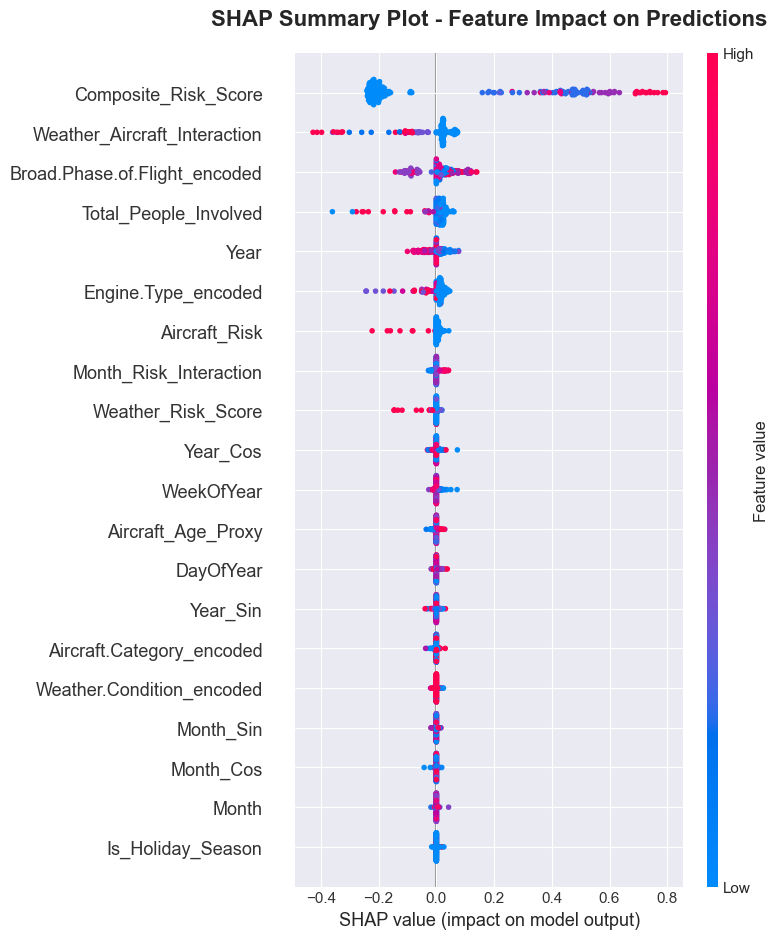

✅ Summary plot saved: shap_summary_plot.png

💡 Interpretation:
   • Each point is a sample
   • Color shows feature value (red=high, blue=low)
   • X-axis shows SHAP value (impact on prediction)
   • Features sorted by importance


In [10]:
if SHAP_AVAILABLE and 'shap_values_global' in locals():
    try:
        print("📊 Creating SHAP Summary Plot...\n")
        
        plt.figure(figsize=(14, 10))
        shap.summary_plot(shap_values_global, X_sample_global,
                         feature_names=feature_names,
                         show=False, max_display=20)
        plt.title('SHAP Summary Plot - Feature Impact on Predictions',
                 fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        
        # Create figures directory if needed
        os.makedirs('../papers/figures', exist_ok=True)
        plt.savefig('../papers/figures/shap_summary_plot.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✅ Summary plot saved: shap_summary_plot.png")
        print("\n💡 Interpretation:")
        print("   • Each point is a sample")
        print("   • Color shows feature value (red=high, blue=low)")
        print("   • X-axis shows SHAP value (impact on prediction)")
        print("   • Features sorted by importance")
        
    except Exception as e:
        print(f"❌ Summary plot failed: {e}")
else:
    print("⚠️ SHAP values not available")

### SHAP Bar Plot - Mean Feature Importance

📊 Creating SHAP Bar Plot...



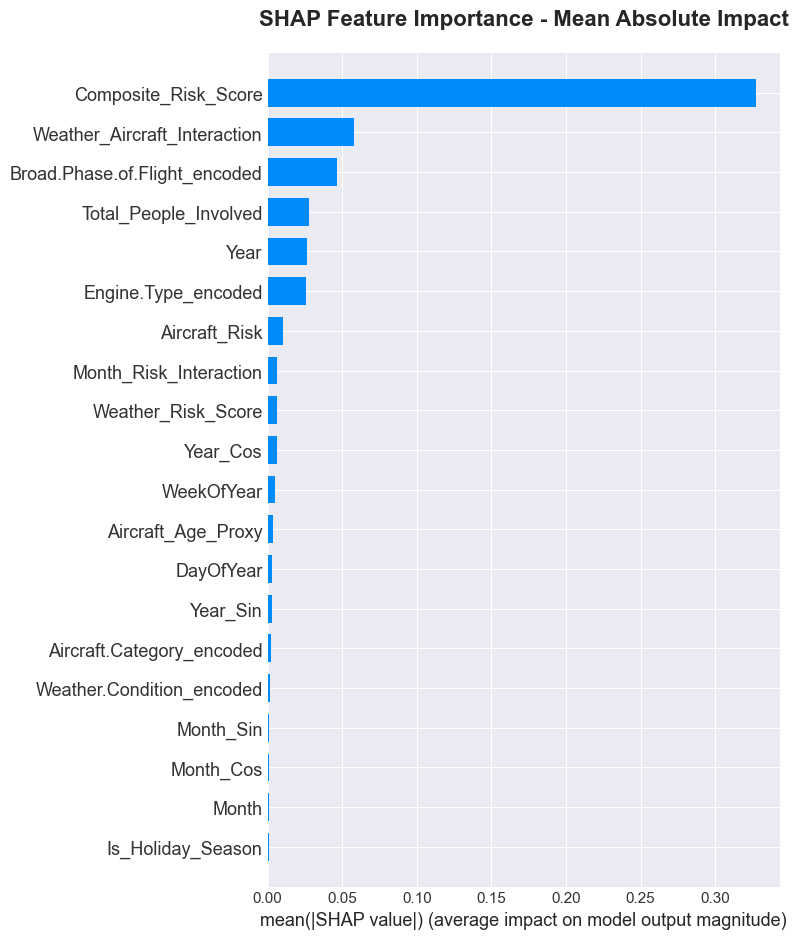

✅ Bar plot saved: shap_bar_plot.png

📋 Top 10 Most Important Features:
   14. Composite_Risk_Score......................... 0.327025
   22. Weather_Aircraft_Interaction................. 0.057802
   20. Broad.Phase.of.Flight_encoded................ 0.046683
   15. Total_People_Involved........................ 0.027741
   1. Year......................................... 0.026230
   18. Engine.Type_encoded.......................... 0.025555
   13. Aircraft_Risk................................ 0.010341
   23. Month_Risk_Interaction....................... 0.006359
   12. Weather_Risk_Score........................... 0.006282
   7. Year_Cos..................................... 0.006010

✅ Feature importance saved: shap_feature_importance.csv


In [11]:
if SHAP_AVAILABLE and 'shap_values_global' in locals():
    try:
        print("📊 Creating SHAP Bar Plot...\n")
        
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values_global, X_sample_global,
                         feature_names=feature_names,
                         plot_type="bar", show=False, max_display=20)
        plt.title('SHAP Feature Importance - Mean Absolute Impact',
                 fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.savefig('../papers/figures/shap_bar_plot.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✅ Bar plot saved: shap_bar_plot.png")
        
        # Calculate and display top features
        mean_shap = np.abs(shap_values_global).mean(axis=0)
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Mean |SHAP|': mean_shap
        }).sort_values('Mean |SHAP|', ascending=False)
        
        print("\n📋 Top 10 Most Important Features:")
        for idx, row in feature_importance.head(10).iterrows():
            print(f"   {idx+1}. {row['Feature']:.<45} {row['Mean |SHAP|']:.6f}")
        
        # Save feature importance
        os.makedirs('../data/processed', exist_ok=True)
        feature_importance.to_csv('../data/processed/shap_feature_importance.csv', index=False)
        print("\n✅ Feature importance saved: shap_feature_importance.csv")
        
    except Exception as e:
        print(f"❌ Bar plot failed: {e}")
else:
    print("⚠️ SHAP values not available")

### SHAP Dependence Plots - Feature Interactions

📊 Creating SHAP Dependence Plots (Top 3 Features)...



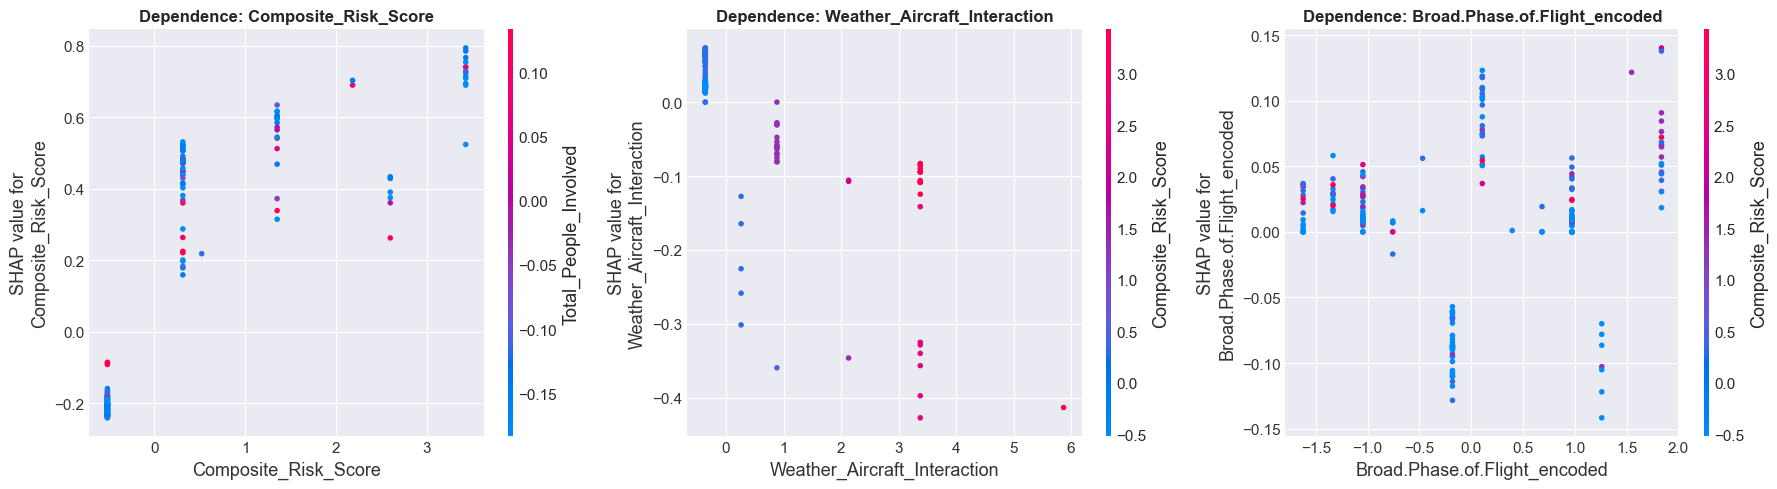

✅ Dependence plots saved: shap_dependence_plots.png

💡 Interpretation:
   • Shows how feature values affect SHAP values
   • Color indicates interaction with another feature
   • Reveals non-linear relationships


In [12]:
if SHAP_AVAILABLE and 'shap_values_global' in locals():
    try:
        print("📊 Creating SHAP Dependence Plots (Top 3 Features)...\n")
        
        # Get top 3 features
        mean_shap = np.abs(shap_values_global).mean(axis=0)
        top_indices = np.argsort(mean_shap)[-3:][::-1]
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        for i, idx in enumerate(top_indices):
            shap.dependence_plot(
                idx, shap_values_global, X_sample_global,
                feature_names=feature_names,
                show=False, ax=axes[i]
            )
            axes[i].set_title(f'Dependence: {feature_names[idx]}',
                            fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('../papers/figures/shap_dependence_plots.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✅ Dependence plots saved: shap_dependence_plots.png")
        print("\n💡 Interpretation:")
        print("   • Shows how feature values affect SHAP values")
        print("   • Color indicates interaction with another feature")
        print("   • Reveals non-linear relationships")
        
    except Exception as e:
        print(f"❌ Dependence plots failed: {e}")
else:
    print("⚠️ SHAP values not available")

### SHAP Waterfall Plot - Individual Prediction Explanation

📊 Creating SHAP Waterfall Plot...

Selected instance: #76
Predicted probability: 0.998
Actual label: Severe



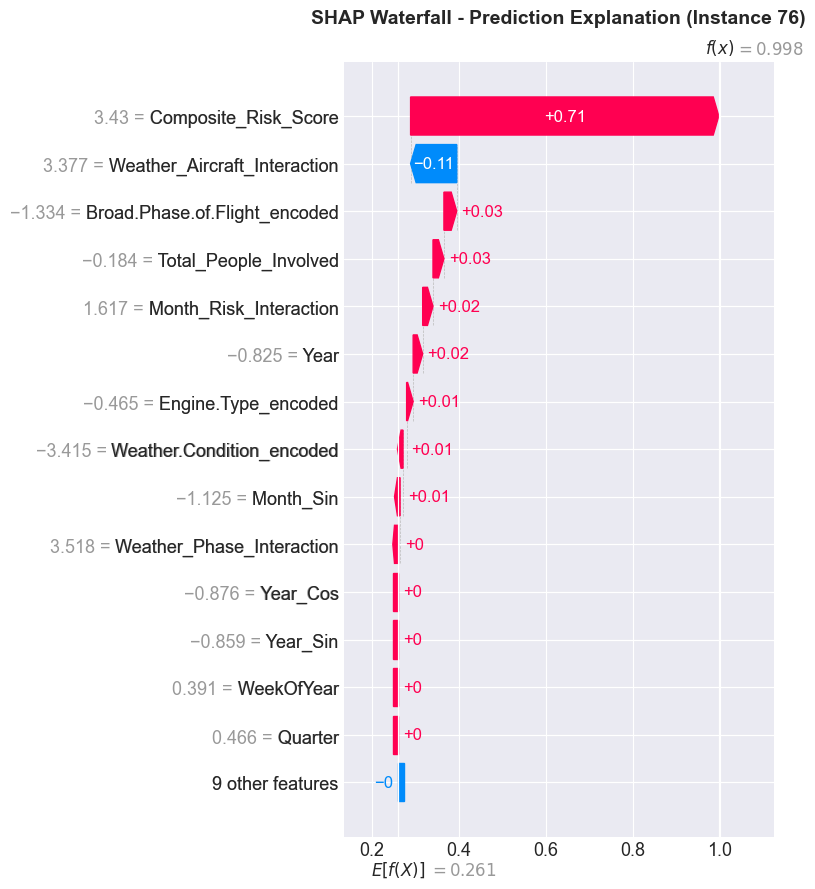

✅ Waterfall plot saved: shap_waterfall_plot.png

💡 Interpretation:
   • Shows how features push prediction up or down
   • Starts from base value (expected output)
   • Each feature adds or subtracts from prediction


In [13]:
if SHAP_AVAILABLE and 'shap_values_global' in locals():
    try:
        print("📊 Creating SHAP Waterfall Plot...\n")
        
        # Select an interesting prediction (high confidence)
        pred_proba = model.predict_proba(X_sample_global)[:, 1]
        high_conf_idx = np.argmax(pred_proba)
        
        print(f"Selected instance: #{high_conf_idx}")
        print(f"Predicted probability: {pred_proba[high_conf_idx]:.3f}")
        print(f"Actual label: {'Severe' if y_sample.iloc[high_conf_idx] == 1 else 'Not Severe'}\n")
        
        plt.figure(figsize=(12, 8))
        shap.plots.waterfall(
            shap.Explanation(
                values=shap_values_global[high_conf_idx],
                base_values=expected_value,
                data=X_sample_global.iloc[high_conf_idx].values,
                feature_names=feature_names
            ),
            show=False, max_display=15
        )
        plt.title(f'SHAP Waterfall - Prediction Explanation (Instance {high_conf_idx})',
                 fontsize=14, fontweight='bold', pad=10)
        plt.tight_layout()
        plt.savefig('../papers/figures/shap_waterfall_plot.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✅ Waterfall plot saved: shap_waterfall_plot.png")
        print("\n💡 Interpretation:")
        print("   • Shows how features push prediction up or down")
        print("   • Starts from base value (expected output)")
        print("   • Each feature adds or subtracts from prediction")
        
    except Exception as e:
        print(f"❌ Waterfall plot failed: {e}")
else:
    print("⚠️ SHAP values not available")

### SHAP Force Plot - Visual Prediction Breakdown

📊 Creating SHAP Force Plot...



<Figure size 1400x400 with 0 Axes>

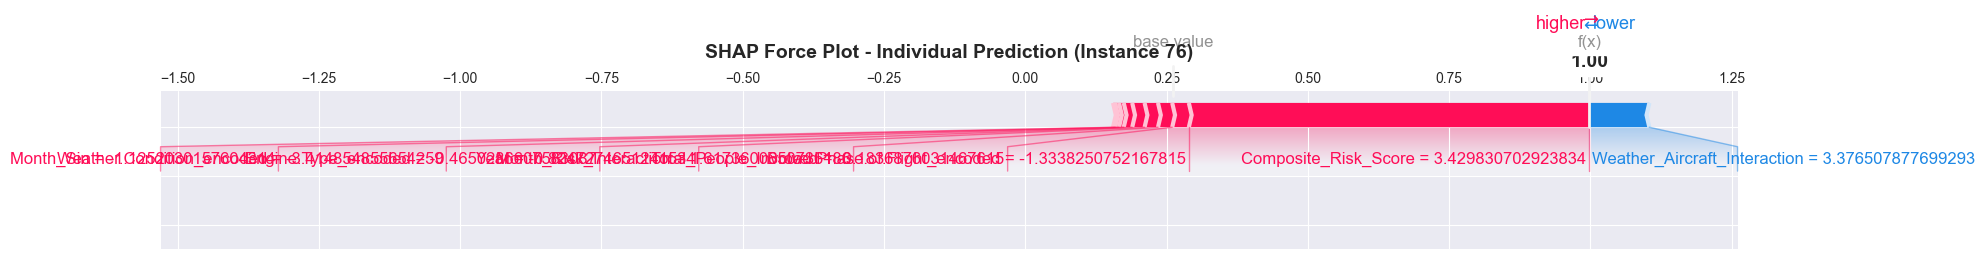

✅ Force plot saved: shap_force_plot.png

💡 Interpretation:
   • Red arrows push prediction higher (towards Severe)
   • Blue arrows push prediction lower (towards Not Severe)
   • Width shows magnitude of impact


In [14]:
if SHAP_AVAILABLE and 'shap_values_global' in locals():
    try:
        print("📊 Creating SHAP Force Plot...\n")
        
        # Use same high confidence instance
        plt.figure(figsize=(14, 4))
        shap.plots.force(
            expected_value,
            shap_values_global[high_conf_idx],
            X_sample_global.iloc[high_conf_idx],
            feature_names=feature_names,
            matplotlib=True, show=False
        )
        plt.title(f'SHAP Force Plot - Individual Prediction (Instance {high_conf_idx})',
                 fontsize=14, fontweight='bold', pad=10)
        plt.tight_layout()
        plt.savefig('../papers/figures/shap_force_plot.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✅ Force plot saved: shap_force_plot.png")
        print("\n💡 Interpretation:")
        print("   • Red arrows push prediction higher (towards Severe)")
        print("   • Blue arrows push prediction lower (towards Not Severe)")
        print("   • Width shows magnitude of impact")
        
    except Exception as e:
        print(f"⚠️ Force plot failed: {e}")
        print("   (Force plots may not work with all matplotlib versions)")
else:
    print("⚠️ SHAP values not available")

## Section 5: LIME Analysis - Local Interpretability

LIME provides model-agnostic explanations by:
- Training simple models locally around predictions
- Showing feature contributions for individual instances
- Providing human-readable explanations

In [4]:
print("\n🍋 LIME ANALYSIS - LOCAL INTERPRETABILITY")
print("="*80)

if not LIME_AVAILABLE:
    print("⚠️ LIME not available. Install with: pip install lime")
else:
    try:
        print("⏳ Creating LIME explainer...\n")
        
        # Create LIME explainer
        explainer_lime = lime.lime_tabular.LimeTabularExplainer(
            X_train.values,
            feature_names=feature_names,
            class_names=['Not Severe', 'Severe'],
            mode='classification',
            random_state=42,
            verbose=False
        )
        
        print("✅ LIME explainer created!")
        print(f"Training data: {X_train.shape}")
        print(f"Features: {len(feature_names)}\n")
        
        lime_explainer = explainer_lime
        
    except Exception as e:
        print(f"❌ LIME explainer creation failed: {e}")
        LIME_AVAILABLE = False


🍋 LIME ANALYSIS - LOCAL INTERPRETABILITY
⏳ Creating LIME explainer...

✅ LIME explainer created!
Training data: (67986, 23)
Features: 23



### LIME Explanations for Multiple Instances

📊 Generating LIME Explanations...

High Confidence Severe (Instance 11366):
   Predicted: [Not Severe: 0.001, Severe: 0.999]
   Actual: Severe
   ✅ Explanation generated

High Confidence Not Severe (Instance 14954):
   Predicted: [Not Severe: 1.000, Severe: 0.000]
   Actual: Not Severe
   ✅ Explanation generated

Borderline Case (Instance 2190):
   Predicted: [Not Severe: 0.500, Severe: 0.500]
   Actual: Not Severe
   ✅ Explanation generated



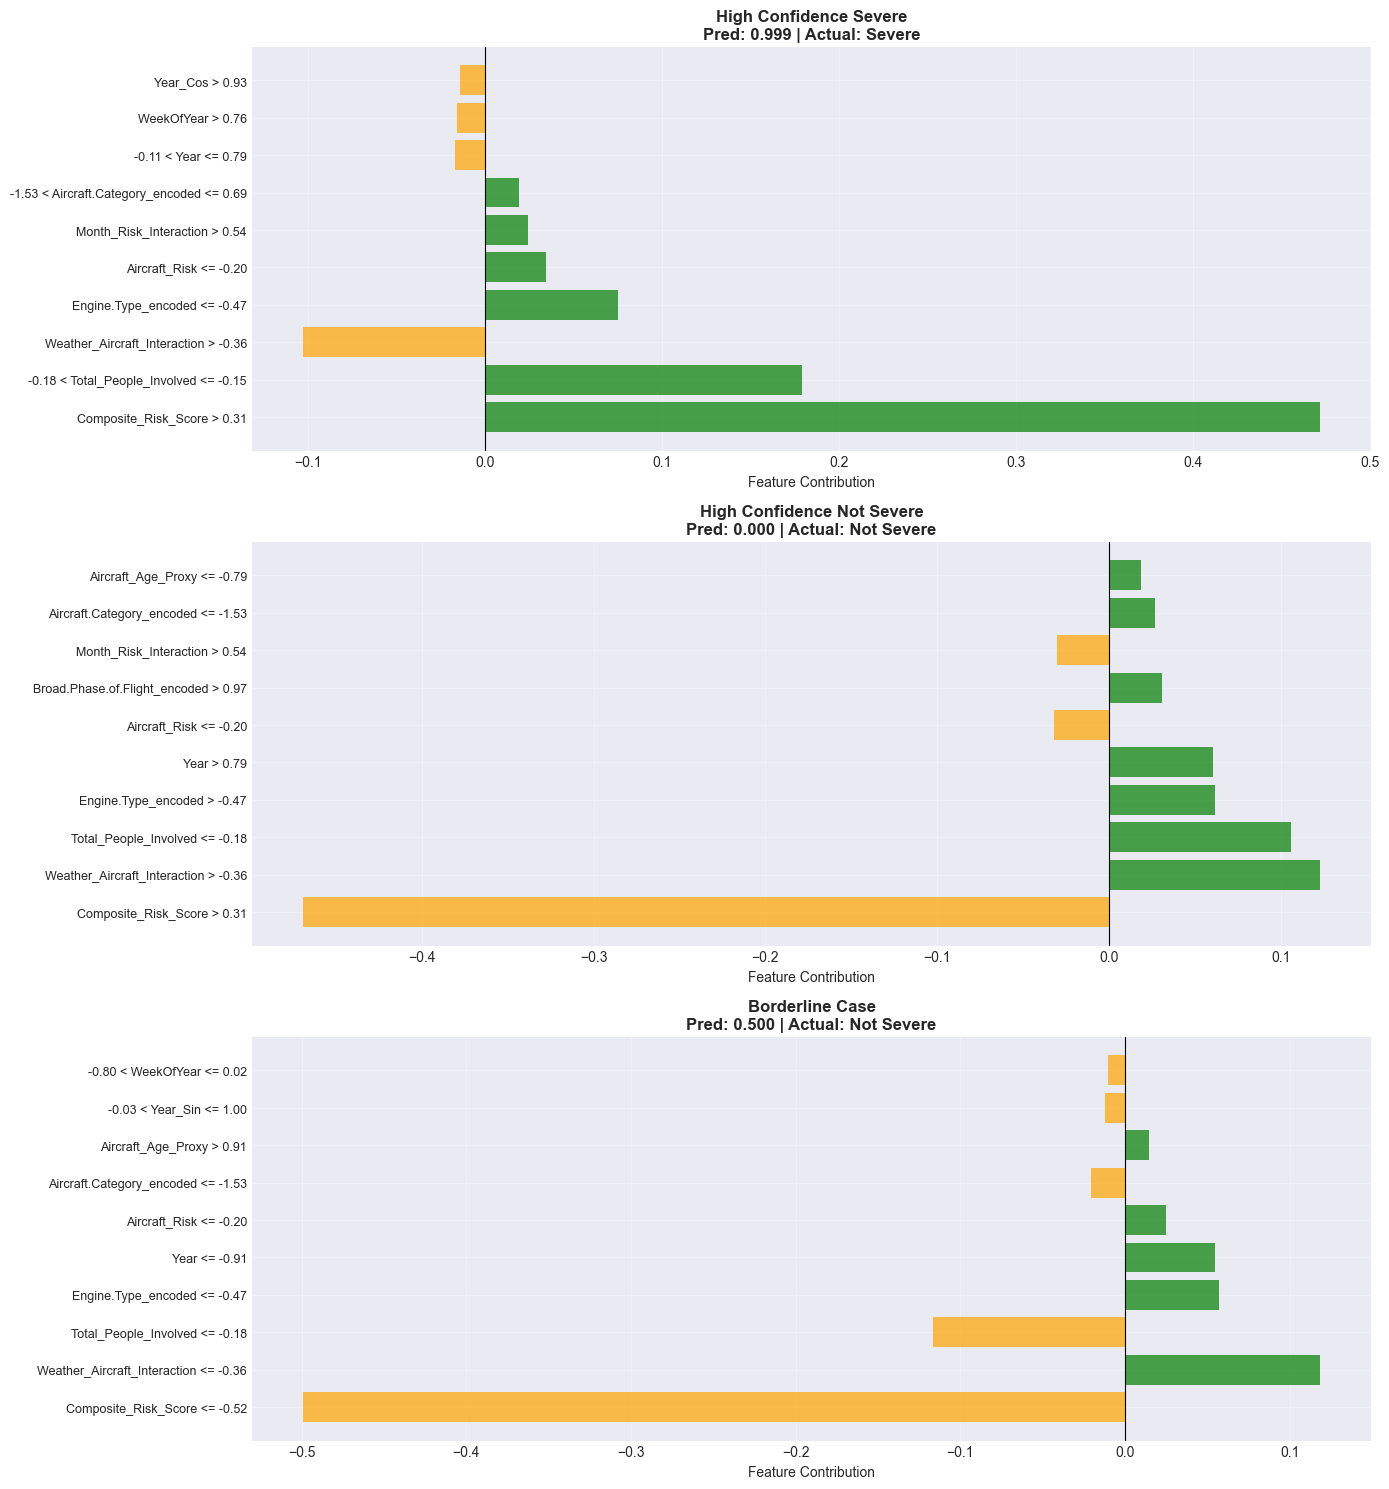

✅ LIME explanations saved: lime_explanations.png

💡 Interpretation:
   • Green bars push towards 'Severe' class
   • Orange bars push towards 'Not Severe' class
   • Values show feature contribution weights


In [7]:
if LIME_AVAILABLE and 'lime_explainer' in locals():
    try:
        print("📊 Generating LIME Explanations...\n")
        
        # Select diverse instances
        pred_proba_test = model.predict_proba(X_test)[:, 1]
        
        high_severe_idx = np.argmax(pred_proba_test)
        high_not_severe_idx = np.argmin(pred_proba_test)
        borderline_idx = np.argmin(np.abs(pred_proba_test - 0.5))
        
        selected_indices = [high_severe_idx, high_not_severe_idx, borderline_idx]
        instance_labels = ['High Confidence Severe', 'High Confidence Not Severe', 'Borderline Case']
        
        fig, axes = plt.subplots(3, 1, figsize=(14, 15))
        
        for i, (idx, label) in enumerate(zip(selected_indices, instance_labels)):
            instance = X_test.iloc[idx].values
            pred = model.predict_proba([instance])[0]
            actual = y_test.iloc[idx]
            
            print(f"{label} (Instance {idx}):")
            print(f"   Predicted: [Not Severe: {pred[0]:.3f}, Severe: {pred[1]:.3f}]")
            print(f"   Actual: {'Severe' if actual == 1 else 'Not Severe'}")
            
            # Generate LIME explanation
            exp = lime_explainer.explain_instance(
                instance, model.predict_proba,
                num_features=10, top_labels=1
            )
            
            # Extract and plot manually (LIME's as_pyplot_figure doesn't support ax)
            exp_list = exp.as_list(label=exp.available_labels()[0])
            features = [feat for feat, _ in exp_list]
            values = [val for _, val in exp_list]
            colors = ['green' if v > 0 else 'orange' for v in values]
            
            axes[i].barh(range(len(features)), values, color=colors, alpha=0.7)
            axes[i].set_yticks(range(len(features)))
            axes[i].set_yticklabels(features, fontsize=9)
            axes[i].set_xlabel('Feature Contribution', fontsize=10)
            axes[i].set_title(f'{label}\nPred: {pred[1]:.3f} | Actual: {"Severe" if actual == 1 else "Not Severe"}',
                            fontsize=12, fontweight='bold')
            axes[i].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
            axes[i].grid(True, alpha=0.3)
            
            print(f"   ✅ Explanation generated\n")
        
        plt.tight_layout()
        plt.savefig('../papers/figures/lime_explanations.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✅ LIME explanations saved: lime_explanations.png")
        print("\n💡 Interpretation:")
        print("   • Green bars push towards 'Severe' class")
        print("   • Orange bars push towards 'Not Severe' class")
        print("   • Values show feature contribution weights")
        
    except Exception as e:
        print(f"❌ LIME explanations failed: {e}")
        import traceback
        traceback.print_exc()
else:
    print("⚠️ LIME explainer not available")

### LIME Text Explanations

In [5]:
if LIME_AVAILABLE and 'lime_explainer' in locals():
    print("📝 Generating Detailed LIME Text Explanations...\n")
    
    # Redefine indices
    pred_proba_test = model.predict_proba(X_test)[:, 1]
    high_severe_idx = np.argmax(pred_proba_test)
    high_not_severe_idx = np.argmin(pred_proba_test)
    borderline_idx = np.argmin(np.abs(pred_proba_test - 0.5))
    
    selected_indices = [high_severe_idx, high_not_severe_idx, borderline_idx]
    instance_labels = ['High Confidence Severe', 'High Confidence Not Severe', 'Borderline Case']
    
    explanations_text = []
    success_count = 0
    
    for idx, label in zip(selected_indices, instance_labels):
        try:
            instance = X_test.iloc[idx].values
            pred = model.predict_proba([instance])[0]
            actual = y_test.iloc[idx]
            
            exp = lime_explainer.explain_instance(
                instance,
                model.predict_proba,
                num_features=10,
                top_labels=1
            )
            
            # Get the label to use
            exp_label = exp.available_labels()[0]
            
            # Extract explanation
            explanation_text = f"\n{'='*80}\n"
            explanation_text += f"{label} (Test Instance #{idx})\n"
            explanation_text += f"{'-'*80}\n"
            explanation_text += f"Prediction: Severe = {pred[1]:.4f}, Not Severe = {pred[0]:.4f}\n"
            explanation_text += f"Actual Label: {'Severe' if actual == 1 else 'Not Severe'}\n"
            explanation_text += f"\nTop Contributing Features:\n"
            
            # Get feature explanations
            exp_list = exp.as_list(label=exp_label)
            for feature, weight in exp_list:
                direction = "→ Severe" if weight > 0 else "→ Not Severe"
                explanation_text += f"  • {feature:.<60} {weight:>8.4f} {direction}\n"
            
            explanations_text.append(explanation_text)
            print(explanation_text)
            success_count += 1
            
        except Exception as inner_e:
            print(f"⚠️ Skipped {label} (Index {idx}): {inner_e}\n")
            continue
    
    # Save to file if we got any explanations
    if explanations_text:
        try:
            with open('../papers/lime_explanations_report.txt', 'w', encoding='utf-8') as f:
                f.write("LIME EXPLANATIONS REPORT\n")
                f.write("Aviation Safety Model - Local Interpretability Analysis\n")
                f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
                for text in explanations_text:
                    f.write(text)
            
            print(f"✅ Text explanations saved ({success_count}/{len(selected_indices)} instances): lime_explanations_report.txt")
        except Exception as save_e:
            print(f"⚠️ Could not save file: {save_e}")
    else:
        print("⚠️ No explanations were generated successfully")
else:
    print("⚠️ LIME explainer not available")

📝 Generating Detailed LIME Text Explanations...


High Confidence Severe (Test Instance #11366)
--------------------------------------------------------------------------------
Prediction: Severe = 0.9988, Not Severe = 0.0012
Actual Label: Severe

Top Contributing Features:
  • Composite_Risk_Score > 0.31.................................   0.4703 → Severe
  • -0.18 < Total_People_Involved <= -0.15......................   0.1583 → Severe
  • Weather_Aircraft_Interaction > -0.36........................  -0.1248 → Not Severe
  • Engine.Type_encoded <= -0.47................................   0.0636 → Severe
  • Aircraft_Risk <= -0.20......................................   0.0332 → Severe
  • -1.53 < Aircraft.Category_encoded <= 0.69...................   0.0295 → Severe
  • Month_Risk_Interaction > 0.54...............................   0.0290 → Severe
  • -0.99 < Year_Sin <= -0.03...................................   0.0170 → Severe
  • WeekOfYear > 0.76....................................

## Section 6: Comparison and Summary

In [15]:
print("\n📊 EXPLAINABILITY ANALYSIS SUMMARY")
print("="*80)

summary = {
    'Analysis Date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'Model': model_name,
    'Model Type': type(model).__name__,
    'Samples Analyzed': len(X_test),
    'Features': len(feature_names),
    'SHAP Analysis': '✅ Completed' if SHAP_AVAILABLE and 'shap_values_global' in locals() else '❌ Failed',
    'LIME Analysis': '✅ Completed' if LIME_AVAILABLE and 'lime_explainer' in locals() else '❌ Failed'
}

print("\n📋 Analysis Summary:")
for key, value in summary.items():
    print(f"   {key:.<40} {value}")

print("\n📁 Generated Files:")
files_generated = []

if SHAP_AVAILABLE and 'shap_values_global' in locals():
    print("\n   SHAP Visualizations:")
    shap_files = [
        'shap_summary_plot.png',
        'shap_bar_plot.png',
        'shap_dependence_plots.png',
        'shap_waterfall_plot.png',
        'shap_force_plot.png'
    ]
    for f in shap_files:
        if os.path.exists(f'../papers/figures/{f}'):
            print(f"      ✅ {f}")
            files_generated.append(f)
    
    if os.path.exists('../data/processed/shap_feature_importance.csv'):
        print("      ✅ shap_feature_importance.csv")
        files_generated.append('shap_feature_importance.csv')

if LIME_AVAILABLE and 'lime_explainer' in locals():
    print("\n   LIME Visualizations:")
    if os.path.exists('../papers/figures/lime_explanations.png'):
        print("      ✅ lime_explanations.png")
        files_generated.append('lime_explanations.png')
    if os.path.exists('../papers/lime_explanations_report.txt'):
        print("      ✅ lime_explanations_report.txt")
        files_generated.append('lime_explanations_report.txt')

print(f"\n📊 Total Files Generated: {len(files_generated)}")

print("\n" + "="*80)
print("✅ EXPLAINABLE AI ANALYSIS COMPLETE!")
print("="*80)

print("\n🎯 Key Takeaways:")
print("   • SHAP provides global feature importance and interactions")
print("   • LIME offers intuitive local explanations for predictions")
print("   • Both methods help validate model reasoning")
print("   • Use these insights to build trust in model decisions")
print("   • Essential for deployment in safety-critical aviation domain")

print("\n📝 Next Steps:")
print("   1. Review generated visualizations in papers/figures/")
print("   2. Include top insights in your research paper")
print("   3. Use explanations to validate domain knowledge")
print("   4. Present to stakeholders for transparency")
print("   5. Document for regulatory compliance")


📊 EXPLAINABILITY ANALYSIS SUMMARY

📋 Analysis Summary:
   Analysis Date........................... 2025-12-26 06:37:56
   Model................................... XGBoost Clean (No Leakage)
   Model Type.............................. XGBClassifier
   Samples Analyzed........................ 16997
   Features................................ 23
   SHAP Analysis........................... ✅ Completed
   LIME Analysis........................... ✅ Completed

📁 Generated Files:

   SHAP Visualizations:
      ✅ shap_summary_plot.png
      ✅ shap_bar_plot.png
      ✅ shap_dependence_plots.png
      ✅ shap_waterfall_plot.png
      ✅ shap_force_plot.png
      ✅ shap_feature_importance.csv

   LIME Visualizations:
      ✅ lime_explanations.png
      ✅ lime_explanations_report.txt

📊 Total Files Generated: 8

✅ EXPLAINABLE AI ANALYSIS COMPLETE!

🎯 Key Takeaways:
   • SHAP provides global feature importance and interactions
   • LIME offers intuitive local explanations for predictions
   • Both me